In [14]:
import matplotlib.pyplot as plt

In [1]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.tree import plot_tree

# 分类器们
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [5]:
from header import numout2boolout

In [12]:
from header import Y,X,x,y

In [5]:
X_featureName=np.load("./processedData/X_featureName.npy")

In [7]:
boolfeature=np.load("./processedData/boolFeature.npy")

In [11]:
onehotfeature=np.load("./processedData/oneHotFeature.npy")

In [8]:
boolfeature

array(['slowCool', 'leak', 'Na', 'Te', 'Br', 'K', 'F', 'I', 'Mo', 'N',
       'P', 'S', 'V', 'Se', 'Zn', 'Co', 'Cl', 'Ga', 'Cr', 'P4', 'P5',
       'G5', 'G6', 'G9', 'G12', 'G13', 'G16', 'V2', 'V3', 'V4', 'V5',
       'V6'], dtype='<U8')

In [6]:
len(set(X_featureName))

264

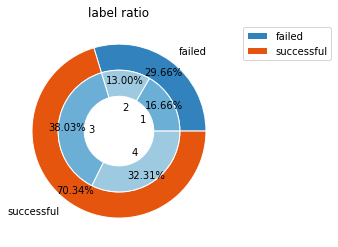

In [15]:
fig, ax = plt.subplots()
size = 0.3
radius=1
vals = np.array([sum(y==i)/len(y) for i in range(1,5)])
cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap(np.array([1, 2]))

ax.pie([vals[0]+vals[1],vals[2]+vals[3]],labels=["failed","successful"],labeldistance=radius+size/2, radius=radius, autopct=lambda pct: "{:.2f}%".format(pct),pctdistance=radius-size/2,colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))
ax.legend(bbox_to_anchor=(1, 0, 0.5, 1))
ax.pie(vals,radius=radius-size, labels=[1,2,3,4], colors=inner_colors,labeldistance=radius-size-size,autopct=lambda pct: "{:.2f}%".format(pct),pctdistance=radius-size/2,
       wedgeprops=dict(width=size, edgecolor='w'))


ax.set_title("label ratio")
plt.show()

In [14]:
len(X_feactureName)

427

In [13]:
onehotfeature

array(['XXXinorg1', 'XXXinorg2', 'XXXinorg3', 'XXXorg1', 'XXXorg2',
       'XXXoxlike1'], dtype='<U10')

In [12]:
len(onehotfeature)

6

数据前处理

X,Y是训练集
x,y是测试集

In [2]:
#处理训练集
raw=pd.read_csv("./data/train.csv")
rawX=raw.loc[:,"XXXinorg1":"purity"]
Y=Y=np.array((raw.loc[:,"outcome"]),dtype=np.float64)
#处理测试集
raw=pd.read_csv("./data/test.csv")
human_pred=np.array(raw.loc[:,"XXX-Intuition"],dtype=np.float64)
ml_pred=np.array(raw.loc[:,"predicted outcome"],dtype=np.float64)
y=np.array(raw.loc[:,"outcome (actual)"],dtype=np.float64)
rawx=raw.loc[:,"XXXinorg1":"purity"]
np.save("./processedData/Y.npy",Y)
np.save("./processedData/y.npy",y)

In [6]:
confusion_matrix(numout2boolout(y),numout2boolout(ml_pred))

array([[  3,  48],
       [ 13, 212]])

In [11]:
precision_score(numout2boolout(y),numout2boolout(ml_pred))

0.8153846153846154

In [8]:
recall_score(numout2boolout(y),numout2boolout(ml_pred))

0.9422222222222222

In [9]:
precision_score(numout2boolout(y),numout2boolout(ml_pred))

0.8153846153846154

In [ ]:
rawXx=pd.concat([rawX,rawx])

In [ ]:
featureName=list(rawXx)

对3个feature进行特判

分为实数型，字符串型，bool型

第二类使用独热编码处理

其中有三个特征比较特殊：
slowCool{'?', 'no', 'yes'}

XXXoxlike1{'-1', -1, 'sodium oxalate'}

leak{'?', 'no', 'yes'}

"no" 赋为0，yes赋1，? 用为yes的概率代替


In [ ]:
X_featureName=[]
Xx=np.array([],dtype=np.float64).reshape(len(rawXx),-1)
boolFeature=[]
oneHotFeature=[]
errorFeature=[]
encoders={}
for i in featureName:
    try:
        feature=np.array(rawXx.loc[:,i],dtype=np.float64).reshape(-1,1)
    except:
        featureval=set(rawXx.loc[:,i])
        if(len(featureval)==1):# 只有一种值的特征，没有帮助
            continue
        elif(featureval==set(["yes","no"])):# bool 型
            feature=np.array(rawXx.loc[:,i]=='yes',dtype=np.float64).reshape(-1,1)
            boolFeature.append(i)
        elif(featureval==set(["yes","no","?"])):# 需要补全的bool 型
            valCnt=rawXx.loc[:,i].value_counts()
            ratio=(valCnt["yes"])/(valCnt['no'])
            feature=np.array((rawXx.loc[:,i]=='yes')
                +((rawXx.loc[:,i]=='?')*(ratio/(1+ratio))),dtype=np.float64).reshape(-1,1)
            boolFeature.append(i)
        else:
            print(i)# 独热型
            ohe=OneHotEncoder()
            feature=ohe.fit_transform(np.array(rawXx.loc[:,i],dtype=str).reshape(-1,1)).toarray()
            if(feature.shape[1]>200):
                errorFeature.append(i)
                continue
            else:
                oneHotFeature.append(i)
                encoders[i]=ohe
    X_featureName+=[i]*(feature.shape[1])
    Xx=np.concatenate((Xx,feature),axis=1)

In [ ]:
X=Xx[:len(rawX),:]
x=Xx[len(rawX):,:]

将处理好的数据放在文件中

In [ ]:
np.save("./processedData/Y.npy",Y)
np.save("./processedData/y.npy",y)
np.save("./processedData/Xx.npy",Xx)
np.save("./processedData/X_featureName.npy",X_featureName)
np.save("./processedData/errorFeature.npy",errorFeature)
np.save("./processedData/oneHotFeature.npy",oneHotFeature)
np.save("./processedData/boolFeature.npy",boolFeature)
np.save("./processedData/encoders.npy",encoders)

SVM

crossValidation
对数据集进行shuffle能显著提高性能,但这是虚假的。作者需要求出未知化合物组合的效果
shuffle=True是随机取样。但是作者的策略是把同一反应物组合的化合物放到一起(恰好在csv中反应物组合近似的放在一起)。则shuffle=False即可。


In [ ]:
def numout2boolout(label):# 结果有1，2，3，4。但是3，4对应人的预测1，1，2
    return label>2.5
def crossValidation(X,y,n_splits,Model,params,shuffle=False):
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    kf=KFold(n_splits=n_splits,shuffle=shuffle)
    print(params)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X_std[train_index], X_std[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        model=Model(**params)
        model.fit(X_train,Y_train)
        tr_pred=model.predict(X_train)
        tr_pred=numout2boolout(tr_pred)
        Y_train=numout2boolout(Y_train)
        print("recall={:.3f}".format(recall_score(Y_train,tr_pred,average='weighted')))
        print("precision={:.3f}".format(precision_score(Y_train,tr_pred,average="weighted")))
        print("accuracy={:.3f}".format(accuracy_score(Y_train,tr_pred)))
        print("confusion matrix is")
        print(confusion_matrix(Y_train,tr_pred))
        
        pred=model.predict(X_test)
        Y_test=numout2boolout(Y_test)
        pred=numout2boolout(pred)
        print("recall={:.3f}".format(recall_score(Y_test,pred,average='weighted')))
        print("precision={:.3f}".format(precision_score(Y_test,pred,average="weighted")))
        print("accuracy={:.3f}".format(accuracy_score(Y_test,pred)))
        print("confusion matrix is")
        print(confusion_matrix(Y_test,pred))

In [ ]:
classifiers = [
    (SVC,{"gamma":2, "C":1}),
    #(GaussianProcessClassifier,{"kernel":1.0 * RBF(1.0)}),# slow
    (DecisionTreeClassifier,{"max_depth":5}),
    (RandomForestClassifier,{"max_depth":5, "n_estimators":10, "max_features":1}),
    (MLPClassifier,{"alpha":1, "max_iter":1000}),
    (AdaBoostClassifier,{}),
    (GaussianNB,{}),
    (QuadraticDiscriminantAnalysis,{})]

In [ ]:
for i in classifiers:
    crossValidation(X,Y,3,i[0],i[1])

文献中使用的svm https://github.com/rlphilli/sklearn-PUK-kernel/blob/master/PUK_kernel.py

以下函数是文献中使用的svm核，效果不如RBF核

In [ ]:
from scipy.spatial.distance import pdist, cdist
from scipy.spatial.distance import squareform

def PUK_kernel(X1,X2, sigma=1.0, omega=1.0):
    # Compute the kernel matrix between two arrays using the Pearson VII function-based universal kernel.
    
    # Compute squared euclidean distance between each row element pair of the two matrices
    if X1 is X2 :
        kernel = squareform(pdist(X1, 'sqeuclidean'))
    else:
        kernel = cdist(X1, X2, 'sqeuclidean')

    kernel = (1 + (kernel * 4 * np.sqrt(2**(1.0/omega)-1)) / sigma**2) ** omega
    kernel = 1/kernel

    return kernel

很糟，train,testset差别太大

In [ ]:
crossValidation(X,Y,3,SVC,{"kernel":PUK_kernel,"class_weight":"balanced","C":1})

将相同反应物的反应聚在一起再shuffle，达到了原文献的效果

reactantMask选择了表示反应物组合的特征。

In [4]:
comb=[]
reactantCombination=[]
reactantMask=["XXXinorg1","XXXinorg2","XXXinorg3","XXXorg1","XXXorg2"]
for i in range(0,len(rawX)):
    try:
        id=comb.index(set(rawX.loc[i,reactantMask]))
        reactantCombination[id].append(i)
    except:
        comb.append(set(rawX.loc[i,reactantMask]))
        reactantCombination.append([i])

def CV_author(X,Y,n_splits,Model,params,shuffle=True):
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    kf=KFold(n_splits=n_splits,shuffle=shuffle)
    print(params)
    for train_index_rc, test_index_rc in kf.split(reactantCombination):
        train_index=[i for rc  in train_index_rc  for i in reactantCombination[rc] ]
        test_index=[i for rc  in test_index_rc  for i in reactantCombination[rc]]
        X_train, X_test = X_std[train_index], X_std[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        model=Model(**params)
        model.fit(X_train,Y_train)
        
        pred=model.predict(X_test)
        Y_test=numout2boolout(Y_test)
        pred=numout2boolout(pred)
        print("recall={:.3f}".format(recall_score(Y_test,pred,average='weighted')))
        print("precision={:.3f}".format(precision_score(Y_test,pred,average="weighted")))
        print("accuracy={:.3f}".format(accuracy_score(Y_test,pred)))
        print("confusion matrix is")
        print(confusion_matrix(Y_test,pred))

In [ ]:
CV_author(X,Y,3,SVC,{"kernel":PUK_kernel,"class_weight":"balanced","C":1})

对测试集的测试

In [ ]:
model=SVC(kernel=PUK_kernel,class_weight="balanced",C=1)
model.fit(X,Y)
pred=model.predict(x)
print(precision_score(numout2boolout(y),numout2boolout(pred)))

将模型解释为决策树, 使用sklearn.tree.plot_tree进行可视化

注意决策树只使用一些特征进行重解释，用tree_X_mask表示

In [ ]:
def reinterpret(X_model,model,X_tree):
    pred=model.predict(X_model)
    ret=DecisionTreeClassifier()
    ret.fit(X_tree,pred)
    return ret
    

In [ ]:
def in_tree_X_mask(s):
    for i in ["orgvanderwaals","orgASA+","orghbdamsdon","PaulingElectronegMean", "hardnessMeanWeighted", "AtomicRadiusMeanWeighted"]:
        if i in s:
            return 1
    return 0

In [ ]:
tree_X_mask=[i for i in range(len(X_featureName)) if in_tree_X_mask(X_featureName[i])]


In [ ]:
tree=reinterpret(X,model,X[:,tree_X_mask])

In [ ]:
plot_tree(tree,max_depth=5,feature_names=[X_featureName[i] for i in tree_X_mask])

特征选择

sklearn应该没有实现CFS方法，但是可以用其他方法，此处没有实现

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

sfm = SelectFromModel(LassoCV(), ).fit(X, y)
toc = time()
print("Features selected by SelectFromModel: "
      f"{feature_names[sfm.get_support()]}")